In [1]:
import json
import os
import pandas as pd
import pprint
import tensorflow as tf
import time
import numpy as np
from tensorflow import keras
import keras
import sys
import h5py
import numpy as np
import os
import keras.backend as K
from keras import initializers

In [2]:
datas = ['./data/sunglasses_poisoned_data.h5','./data/clean_test_data.h5','./data/clean_validation_data.h5']
models = ['./models/anonymous_bd_net.h5','models/sunglasses_bd_net.h5']


def data_loader(filepath):
    
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return data_preprocess(x_data), y_data

def data_preprocess(x_data):
    return x_data/255

def describe(data):
    df_describe = pd.DataFrame(data)
    return df_describe.describe()

In [4]:
  
x_dirty, y_dirty = data_loader(datas[0])
x_test, y_test = data_loader(datas[1])
x_clean, y_clean = data_loader(datas[2])
bd_model = keras.models.load_model(models[1])

clean_label_p = np.argmax(bd_model.predict(x_dirty), axis=1)
class_accu = np.mean(np.equal(clean_label_p, y_dirty))*100
print('Classification accuracy:', class_accu)

Classification accuracy: 99.99220576773187


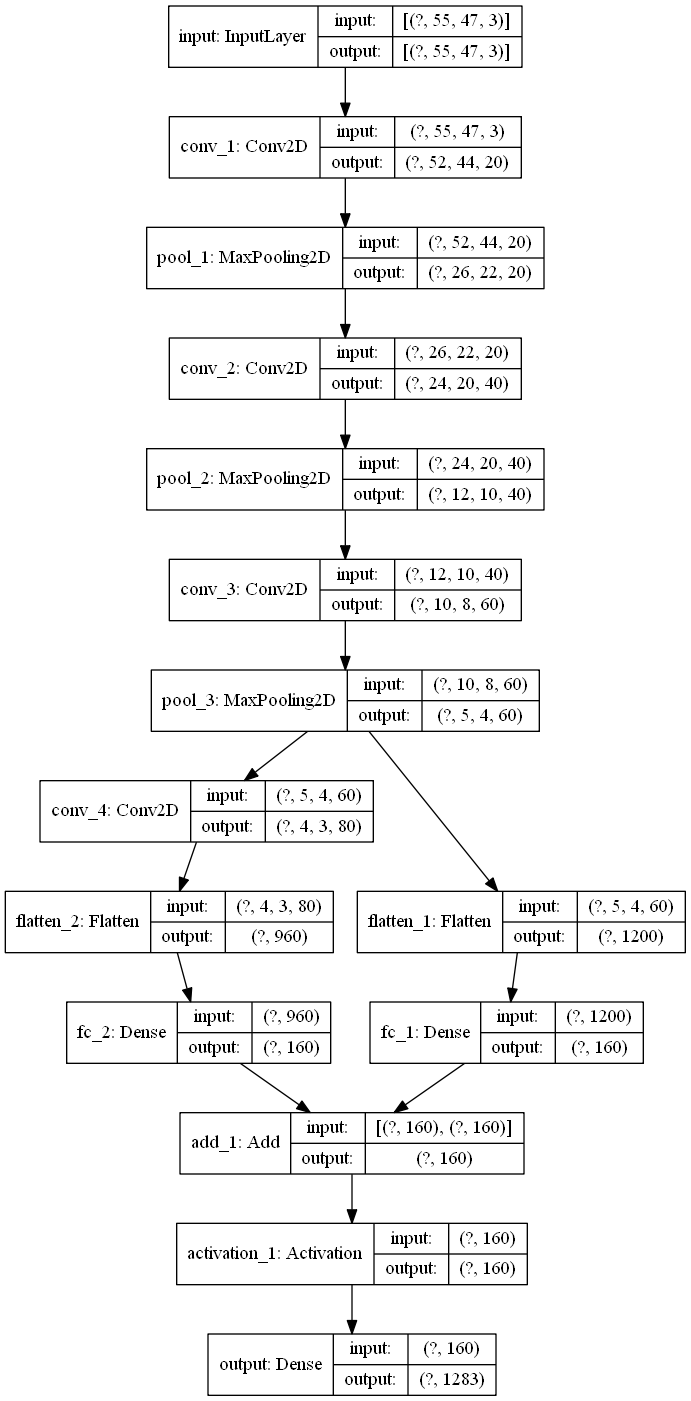

In [5]:
from keras.utils.vis_utils import plot_model

plot_model(bd_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Cropping2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(55, 47, 3))
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size=2, padding='same')(x)

x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(encoded)
x = UpSampling2D(size=2)(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling2D(size=2)(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling2D(size=2)(x)
x = Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(x)

decoded = Cropping2D(cropping=((1, 0), (1, 0)), data_format=None)(x)



In [7]:
"""

# Time comsuming, add the pretrained model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_clean, x_clean,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_split=0.3
               )
"""

"\n\n# Time comsuming, add the pretrained model\nautoencoder = Model(input_img, decoded)\nautoencoder.compile(optimizer='adam', loss='mean_squared_error')\nautoencoder.fit(x_clean, x_clean,\n                epochs=200,\n                batch_size=64,\n                shuffle=True,\n                validation_split=0.3\n               )\n"

In [9]:
autoencoder =  keras.models.load_model("autoencoder1.h5")
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [10]:
repaired =  keras.models.load_model("pruning.h5")
repaired.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
            loss=tf.keras.losses.sparse_categorical_crossentropy, 
            metrics=['accuracy'])
repaired.evaluate(x_clean,y_clean)

361/361 [==============================] - 3s 7ms/step - loss: 0.0268 - accuracy: 0.9907: 0s - loss: 0.0269 - accuracy: 0.


[0.02682710811495781, 0.9907335042953491]

In [11]:
reconstructions = autoencoder.predict(x_clean)
train_loss = tf.keras.losses.mae(reconstructions, x_clean)
threshold = np.mean(train_loss) + np.std(train_loss) + 0.03
print("Threshold: ", threshold)

Threshold:  0.09179428238229165


In [14]:
def encoder_predict(autoencoder,input_x, threshold):
    '''
    Generate mask for detecting the abnomal input. Once the constrcture loss over the threhold,
    we treat it as abnormal input
    
    Args:
        autoencoder(Model): autoencoder model
        input_x (array size with [None,55,47,3]): Input data
        threshold (float): used to detect abnomal input
    
    Retrun:
        res: A mask like [0,1,0,1....] in numpy.array type. 0 is abnormal point, and 1 is validated point
    
    '''
    reconstruction = autoencoder.predict(input_x)
    detect_loss = tf.keras.losses.mae(reconstruction, input_x)
    res = np.fromiter(map(lambda x: 1 if (np.mean(x) + np.std(x))  <= threshold else 0,detect_loss),dtype = int)
    return res

In [15]:
detect_test = encoder_predict(autoencoder,x_test,threshold)

In [44]:
sum(detect_test == 0)

801

In [16]:
detect_clean = encoder_predict(autoencoder,x_clean,threshold)

In [17]:
detect_posioned = encoder_predict(autoencoder,x_dirty,threshold)

In [32]:
def final_predict(autoencoder, repaired_model, x, threshold):
    mask = encoder_predict(autoencoder,x,threshold)
    y_hat = np.argmax(repaired.predict(x), axis=1)
    y_hat[mask == 0] = 1283
    return y_hat

In [33]:
y_clean_hat = final_predict(autoencoder,repaired,x_clean,threshold)

In [34]:
np.mean(np.equal(y_clean_hat, y_clean))*100

93.70399237897288

In [35]:
y_dirty_hat = final_predict(autoencoder,repaired,x_dirty,threshold)

In [36]:
np.mean(np.equal(y_dirty_hat, y_dirty))*100

0.00779423226812159

In [37]:
y_test_hat = final_predict(autoencoder,repaired,x_test,threshold)

In [38]:
np.mean(np.equal(y_test_hat, y_test))*100

82.29150428682775

In [39]:
describe(y_test_hat)

,0
count,12830.000000
mean,681.764147
std,389.322001
min,0.000000
25%,347.250000
50%,690.000000
75%,1024.000000
max,1283.000000


In [46]:
sum(y_dirty_hat == 1283)

12700

In [45]:
sum(y_test_hat == 1283)

801

In [47]:
sum(y_clean == 1283)

0